In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# 데이터 분할:train, test
from sklearn.model_selection import train_test_split
# 분류 Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# 분류모델 평가 함수
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.formula.api as smf

In [2]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
# !apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) # 폰트 설정


Selecting previously unselected package fonts-nanum.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [8]:
dfloan_train = pd.read_csv('/content/drive/MyDrive/포스코 청년 아카데미/Project/미래캐피탈/auto_loan_train.csv', encoding = 'euc-kr')
dfc_train = pd.read_csv('/content/drive/MyDrive/포스코 청년 아카데미/Project/미래캐피탈/auto_customer_train.csv', encoding = 'euc-kr')
dfloan_test = pd.read_csv('/content/drive/MyDrive/포스코 청년 아카데미/Project/미래캐피탈/auto_loan_test.csv', encoding = 'euc-kr')
dfc_test = pd.read_csv('/content/drive/MyDrive/포스코 청년 아카데미/Project/미래캐피탈/auto_customer_test.csv', encoding = 'euc-kr')

# 데이터 전처리

In [9]:
df = pd.merge(dfc_train,dfloan_train, how='right',on='CustomerId')
df = df.drop(['CustomerId','LoanId','HouseAge'], axis = 1)

* CustomerId, LoanId: 분석과 관련없는 열 제거(ID)
* HouseAge: 결측치가 너무 많아 열 제거

In [10]:
# 퇴직자, 재직자 분리
df_em = df[(df['IncomeType'] == '퇴직')]
df = df[(df['IncomeType'] != '퇴직')]

* 재직자와 퇴직자의 특성이 달라(직장, 수입 등) 분할하여 데이터 분석 진행

In [11]:
df_em = df_em[df_em['IncomeClass'] != '누락']
df_em = df_em[df_em['ResidenceClass'] != '누락']
df_em = df_em[df_em['DwellingType'] != '정보누락']

* 누락값 제거

In [12]:
df_em = df_em.dropna(subset=['IdChangedYears'])
df_em = df_em.dropna(subset=['PhoneChangedYears'])

* 결측치(NaN 값) 제거

In [13]:
# 값이 '퇴직'으로 구성된 열 삭제
df_em = df_em.drop(['EmployedYears', 'IncomeType','Occupation','WorkAddMatchedYN'], axis =1)

* 값이 '퇴직'으로 구성된 열 삭제
  ex) IncomeType: 퇴직, Occupation: 퇴직자

In [14]:
df_em['Accompany'].replace(['기타','배우자','친지','자녀','단체'],'동행', inplace = True)

* 동행 혹은 단독으로 범주화

# EDA

### LoanType

In [15]:
df_em['LoanType'].value_counts()

할부금융(장/단기)    12629
오토론            1177
Name: LoanType, dtype: int64

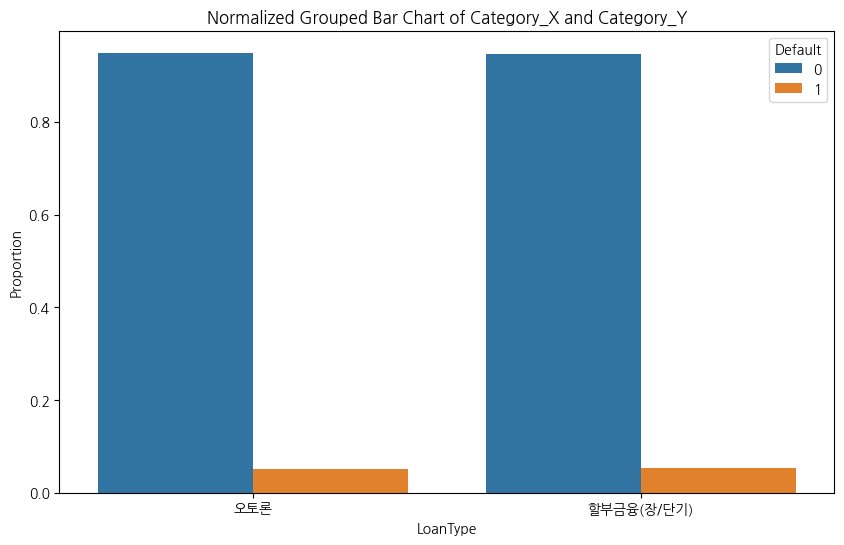

In [16]:
# 데이터 정규화
normalized_counts = df_em.groupby(['LoanType', 'Default']).size() / df_em.groupby('LoanType').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='LoanType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

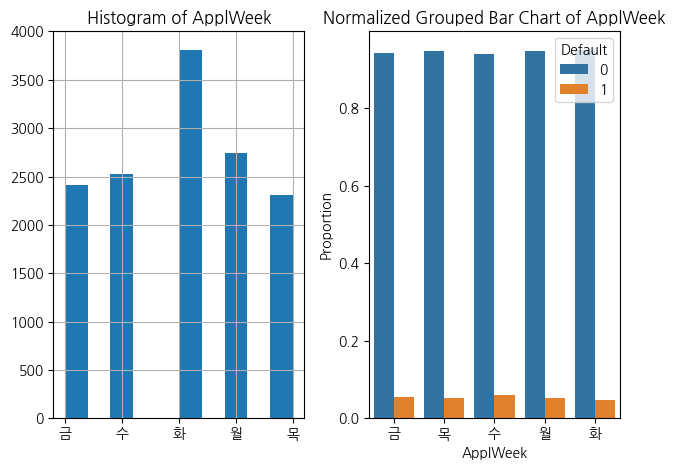

In [17]:
plt.subplot(1, 2, 1)
df_em['ApplWeek'].hist()
plt.title('Histogram of ApplWeek')

# 두 번째 서브플롯 - 그룹별 막대 그래프
plt.subplot(1, 2, 2)
normalized_counts = df_em.groupby(['ApplWeek', 'Default']).size() / df_em.groupby('ApplWeek').size()
sns.barplot(x='ApplWeek', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of ApplWeek')
plt.ylabel('Proportion')

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

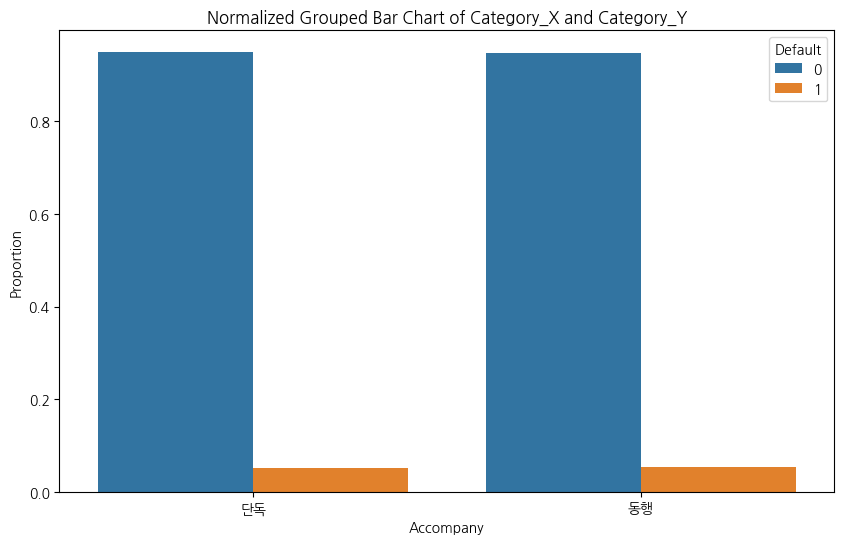

In [18]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Accompany', 'Default']).size() / df_em.groupby('Accompany').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Accompany', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

Text(0, 0.5, 'Proportion')

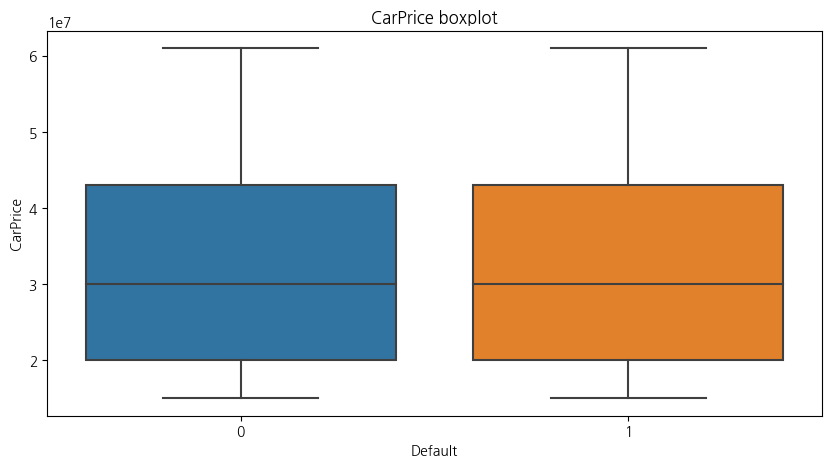

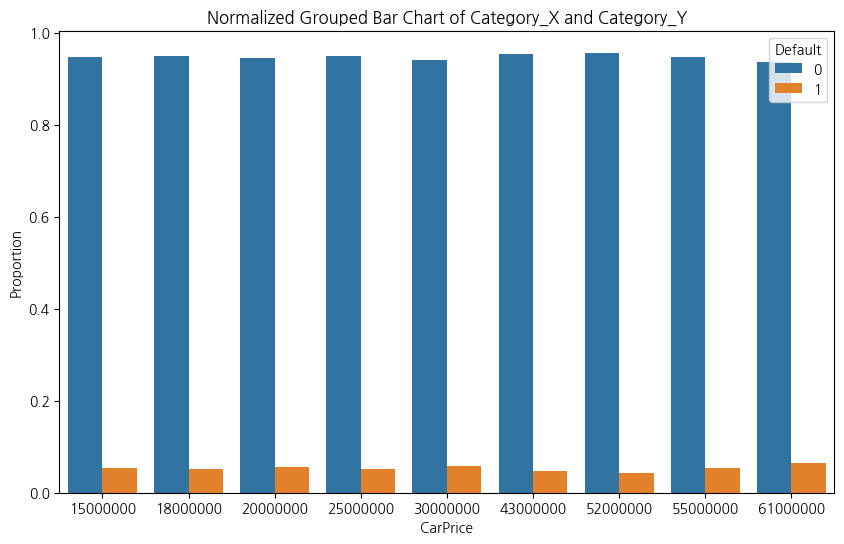

In [19]:
# 데이터 정규화
normalized_counts = df_em.groupby(['CarPrice', 'Default']).size() / df_em.groupby('CarPrice').size()

plt.figure(figsize = (10,5))
sns.boxplot( x = 'Default', y = 'CarPrice', data = df_em)
plt.title('CarPrice boxplot')

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='CarPrice', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')


Text(0.5, 1.0, 'Deposit hist')

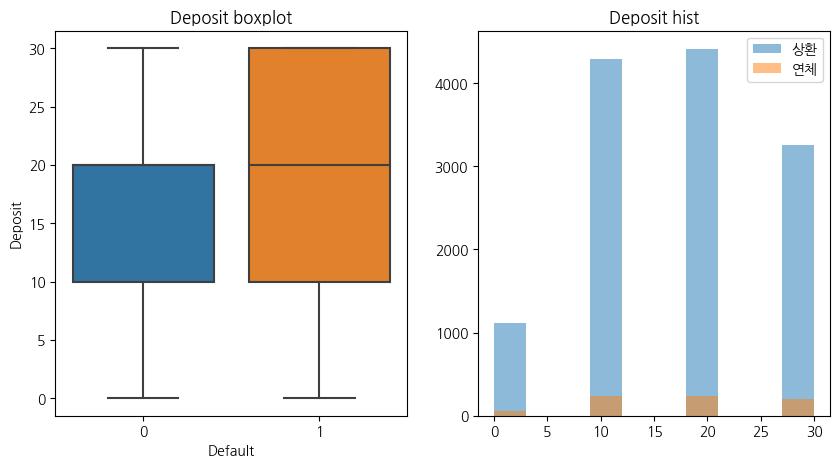

In [20]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot( x = 'Default', y = 'Deposit', data = df_em)
plt.title('Deposit boxplot')

plt.subplot(1,2,2)
plt.hist(df_em[df_em['Default'] == 0]['Deposit'], label = '상환', alpha = 0.5)
plt.hist(df_em[df_em['Default'] == 1]['Deposit'] , label = '연체', alpha = 0.5)
plt.legend()
plt.title('Deposit hist')

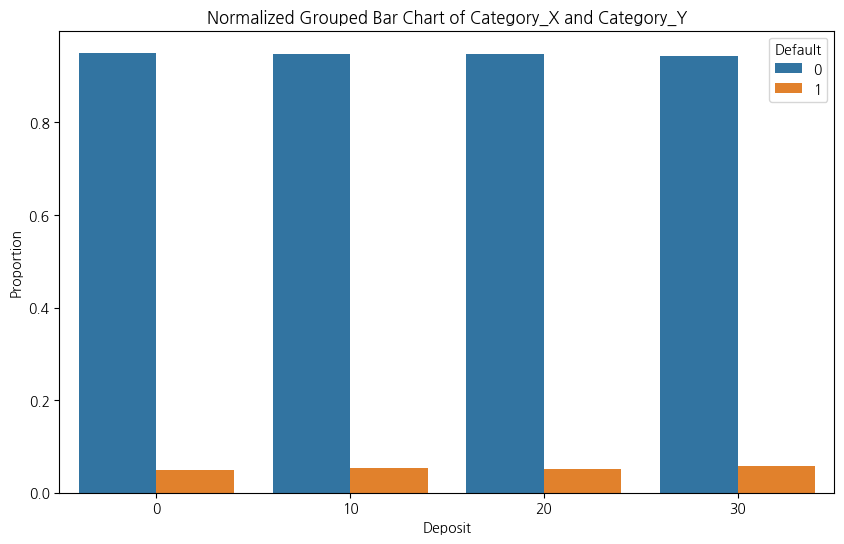

In [21]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Deposit', 'Default']).size() / df_em.groupby('Deposit').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Deposit', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

Text(0.5, 1.0, 'LoanRemainTerm hist')

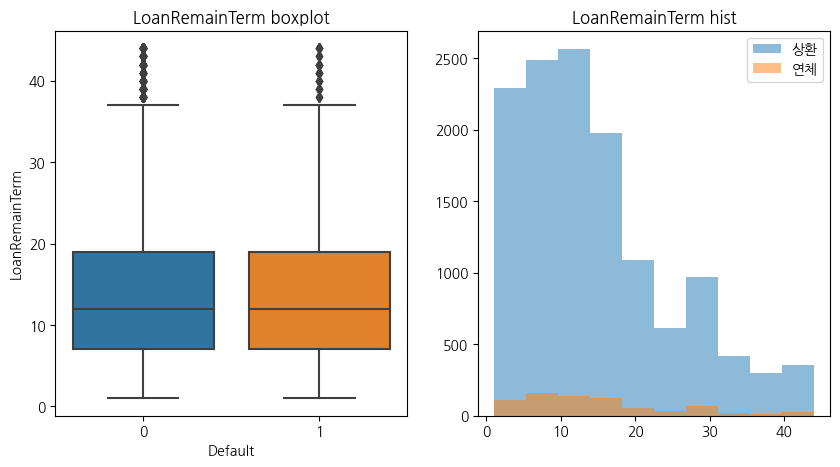

In [22]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.boxplot( x = 'Default', y = 'LoanRemainTerm', data = df_em)
plt.title('LoanRemainTerm boxplot')

plt.subplot(1,2,2)
plt.hist(df_em[df_em['Default'] == 0]['LoanRemainTerm'], label = '상환', alpha = 0.5)
plt.hist(df_em[df_em['Default'] == 1]['LoanRemainTerm'] , label = '연체', alpha = 0.5)
plt.legend()
plt.title('LoanRemainTerm hist')

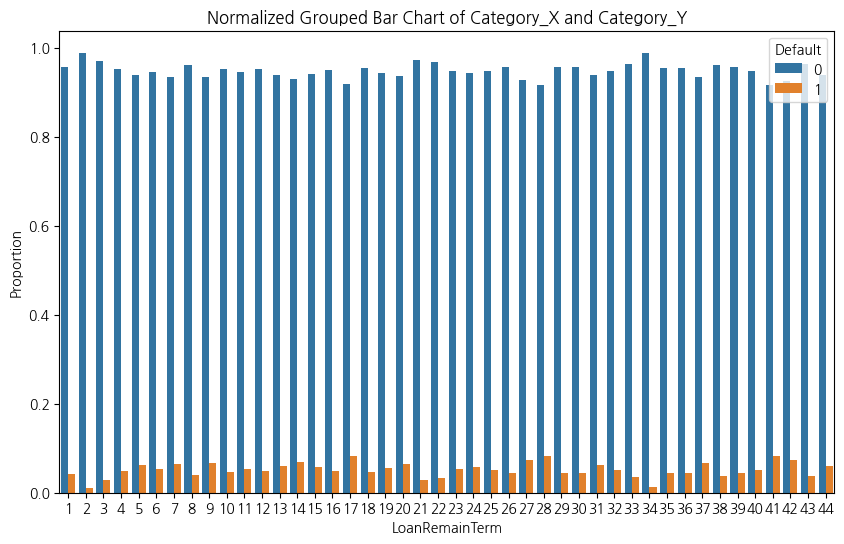

In [23]:
# 데이터 정규화
normalized_counts = df_em.groupby(['LoanRemainTerm', 'Default']).size() / df_em.groupby('LoanRemainTerm').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='LoanRemainTerm', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

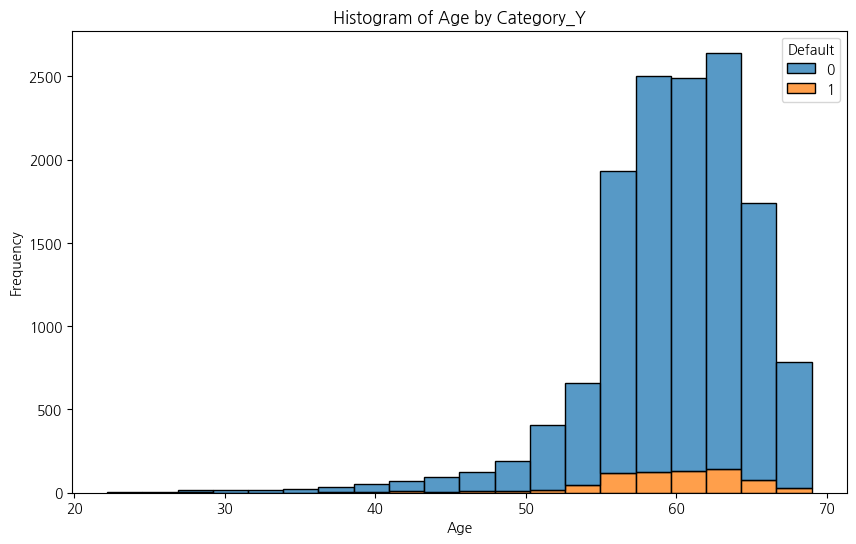

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='Age', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of Age by Category_Y')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

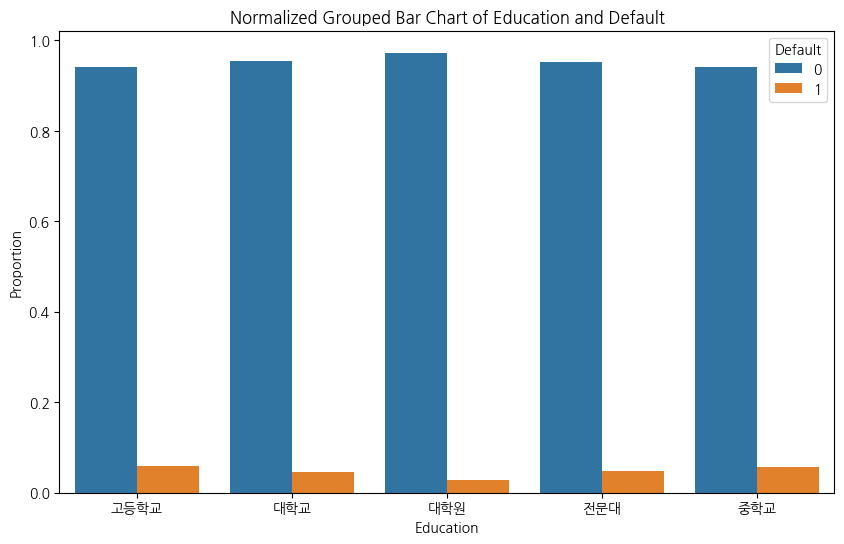

In [25]:
# 데이터 정규화
normalized_counts = df_em.groupby(['Education', 'Default']).size() / df_em.groupby('Education').size()

# 정규화된 데이터로 그룹별 막대 그래프 생성
plt.figure(figsize=(10, 6))
sns.barplot(x='Education', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Education and Default')
plt.ylabel('Proportion')
plt.show()

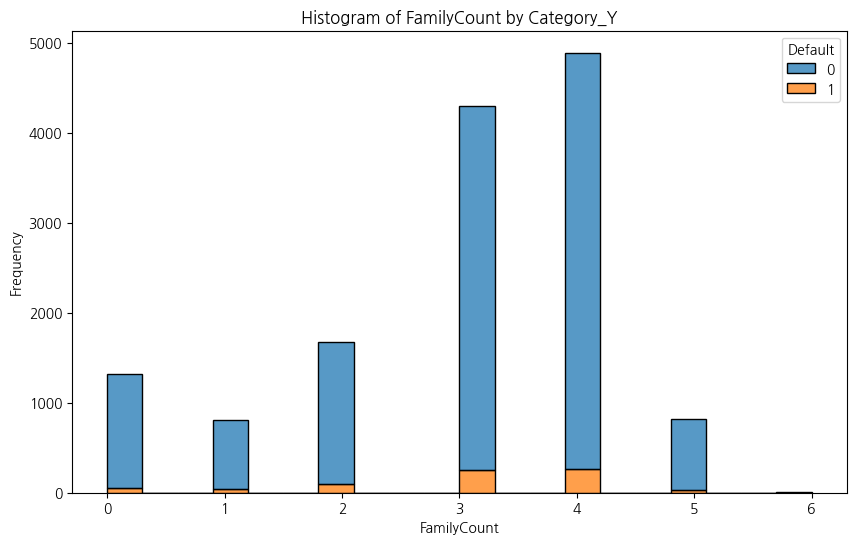

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='FamilyCount', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of FamilyCount by Category_Y')
plt.xlabel('FamilyCount')
plt.ylabel('Frequency')
plt.show()

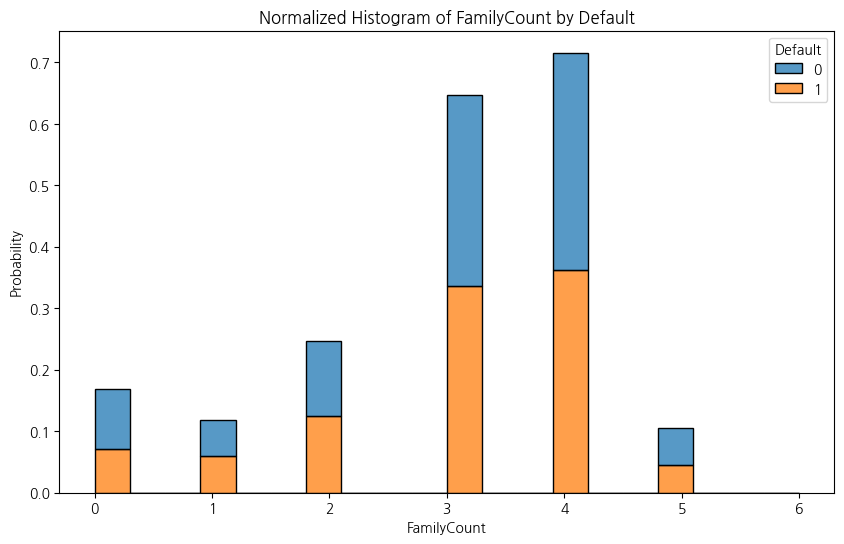

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='FamilyCount', hue='Default', multiple='stack', bins=20, stat='probability', common_norm=False)
plt.title('Normalized Histogram of FamilyCount by Default')
plt.xlabel('FamilyCount')
plt.ylabel('Probability')
plt.show()

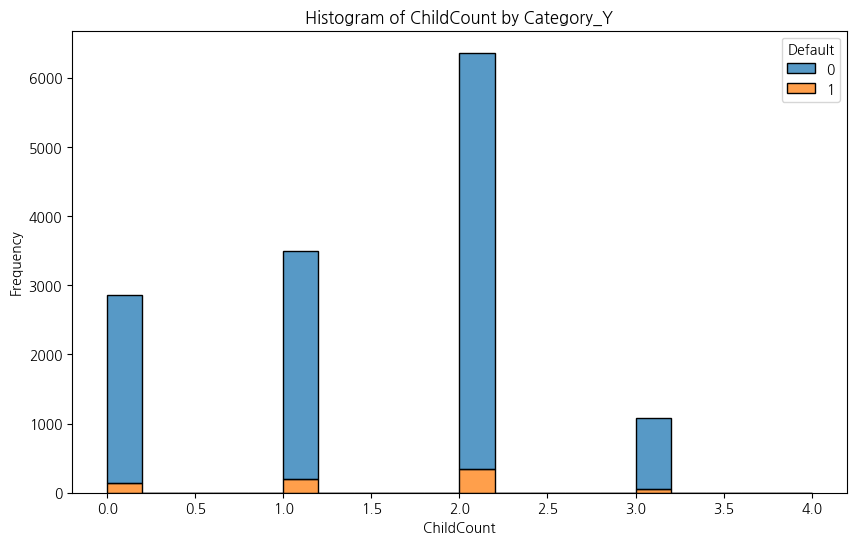

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_em, x='ChildCount', hue='Default', multiple='stack', bins=20)
plt.title('Histogram of ChildCount by Category_Y')
plt.xlabel('ChildCount')
plt.ylabel('Frequency')
plt.show()

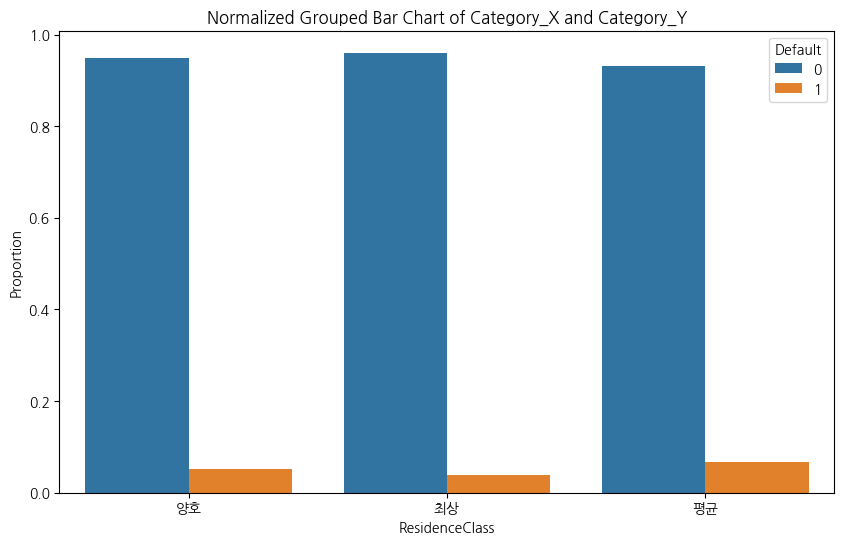

In [29]:
normalized_counts = df_em.groupby(['ResidenceClass', 'Default']).size() / df_em.groupby('ResidenceClass').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='ResidenceClass', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

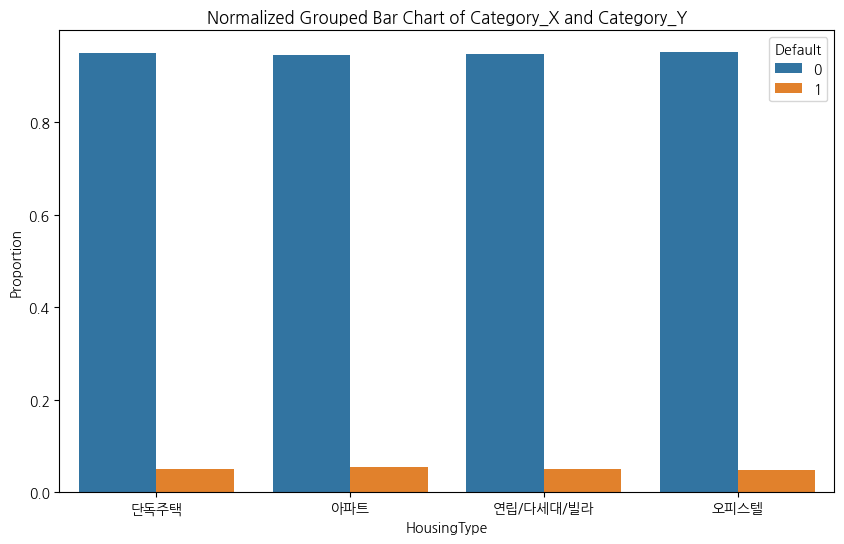

In [30]:
normalized_counts = df_em.groupby(['HousingType', 'Default']).size() / df_em.groupby('HousingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='HousingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

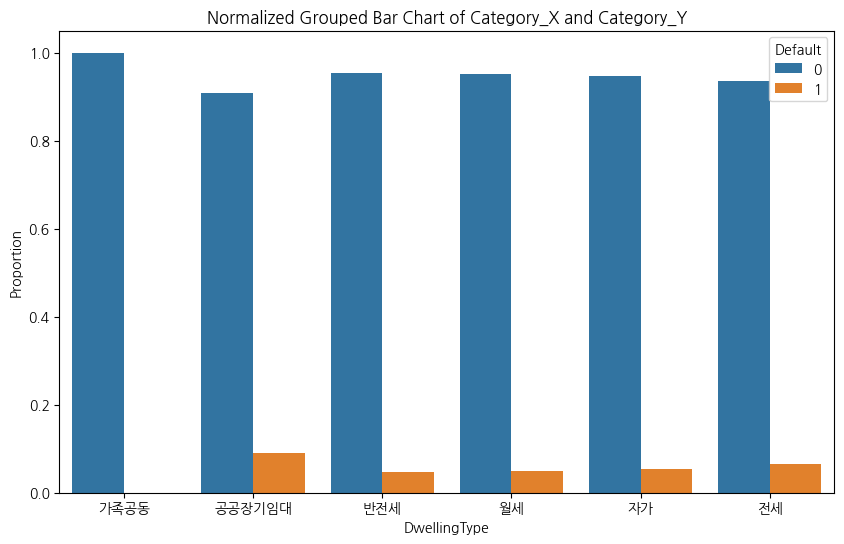

In [31]:
normalized_counts = df_em.groupby(['DwellingType', 'Default']).size() / df_em.groupby('DwellingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='DwellingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

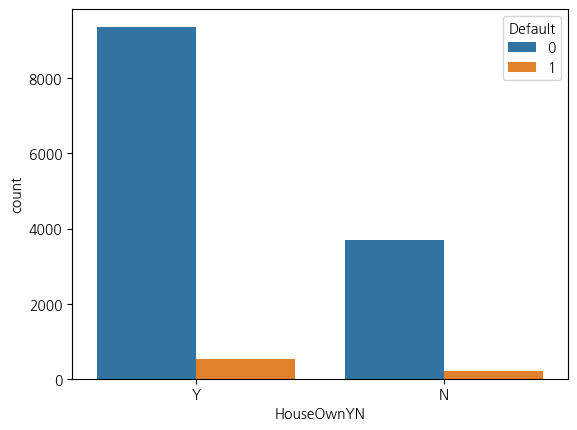

In [32]:
sns.countplot(x='HouseOwnYN', hue='Default', data=df_em)
plt.show()

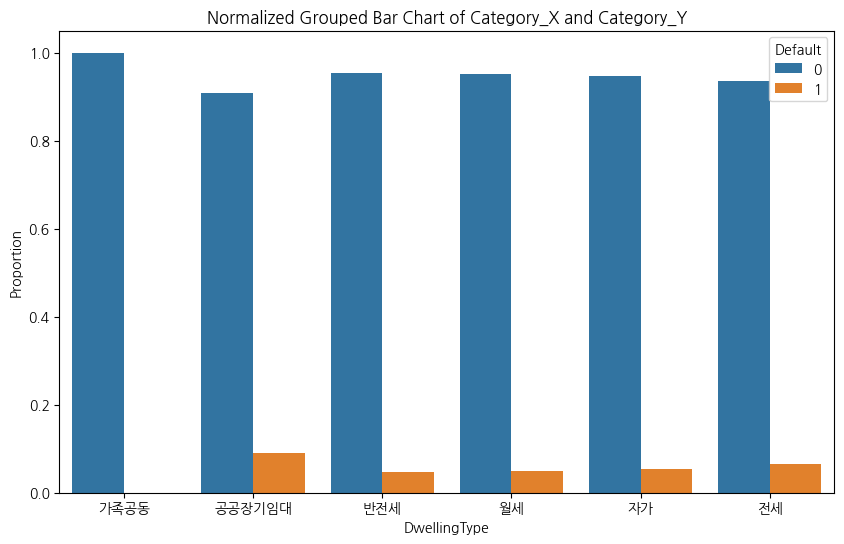

In [33]:
normalized_counts = df_em.groupby(['DwellingType', 'Default']).size() / df_em.groupby('DwellingType').size()

plt.figure(figsize=(10, 6))
sns.barplot(x='DwellingType', y=normalized_counts.values, hue='Default', data=normalized_counts.reset_index())
plt.title('Normalized Grouped Bar Chart of Category_X and Category_Y')
plt.ylabel('Proportion')
plt.show()

* EDA 결과 특이사항 없음 (각 항목에 따른 연체 여부 일정)

# 통계적 검정

## 로지스틱 회귀분석

In [34]:
df_num = df_em.select_dtypes(exclude = "object")
df_num.columns

Index(['Age', 'FamilyCount', 'ChildCount', 'Default', 'ApplHour', 'CarPrice',
       'Deposit', 'LoanTerm', 'LoanRemainTerm', 'InterestRate', 'LoanAmount',
       'InstallAmount', 'LoanRemainAmount', 'InquiryCount', 'IdChangedYears',
       'InfoChangedYears', 'PhoneChangedYears', 'ScoreA', 'ScoreB', 'ScoreC'],
      dtype='object')

In [45]:
from statsmodels.api import Logit

# from_formula 함수를 이용하여 변수 역할 지정
log_model = Logit.from_formula("""Default ~ Age + FamilyCount +
                      ApplHour + CarPrice+ InterestRate + LoanRemainAmount +
                      InquiryCount +IdChangedYears + InfoChangedYears + PhoneChangedYears""", df)
# 적합
log_result = log_model.fit()

# 결과 출력
print(log_result.summary())

con_sign = ['Age', 'FamilyCount','InterestRate', 'ApplHour','CarPrice', 'InquiryCount', 'LoanRemainAmount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']

Optimization terminated successfully.
         Current function value: 0.286048
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                77581
Model:                          Logit   Df Residuals:                    77570
Method:                           MLE   Df Model:                           10
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                 0.01375
Time:                        11:41:34   Log-Likelihood:                -22192.
converged:                       True   LL-Null:                       -22501.
Covariance Type:            nonrobust   LLR p-value:                1.603e-126
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.3134      0.112    -11.710      0.000      -1.533      -1.094
Age     

※ 신뢰도 90% 기반 연속형 변수 검정

연체여부에 유의하지 않은 변수 ['ChildCount', 'Deposit', 'LoanTerm', 'LoanRemainTerm', 'LoanAmount', 'InstallAmount', ]

연체여부에 유의한 변수 ['Age', 'FamilyCount','InterestRate', 'ApplHour','CarPrice', 'InquiryCount', 'LoanRemainAmount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']


## 카이제곱 검정

In [44]:
from scipy.stats import chi2_contingency

cat_unsign = []
cat_sign = []
# 범주형 변수 추출
categorical_cols = df_em.select_dtypes(include=['object']).columns

# 카이제곱 검정 수행
for col in categorical_cols:
    cross_tab = pd.crosstab(df['Default'], df[col])
    chi, p_value, dof, expected = chi2_contingency(cross_tab)

    print(f"{col}:")
    print(f"chi-squared: {chi:.3f}")
    print(f"p-value: {p_value:.3f}")
    print(f"degree of freedom: {dof}")
    print()

    #신뢰도 90%
    if p_value > 0.05 :
        cat_unsign.append(col)
    else:
        cat_sign.append(col)


print("---------------------------------------------------------------------------------------------------------------------------------")
print("")
print("※ 신뢰도 90% 기반")
print("")
print("연체여부에 유의하지 않은 변수 {}".format(cat_unsign))
print("")
print("연체여부에 유의한 변수 {}".format(cat_sign))
print("")

Gender:
chi-squared: 135.131
p-value: 0.000
degree of freedom: 1

Education:
chi-squared: 289.541
p-value: 0.000
degree of freedom: 4

MaritalStatus:
chi-squared: 48.013
p-value: 0.000
degree of freedom: 3

IncomeClass:
chi-squared: 84.735
p-value: 0.000
degree of freedom: 7

OrgType:
chi-squared: 190.487
p-value: 0.000
degree of freedom: 18

HouseOwnYN:
chi-squared: 0.013
p-value: 0.908
degree of freedom: 1

DwellingType:
chi-squared: 46.642
p-value: 0.000
degree of freedom: 6

HousingType:
chi-squared: 0.696
p-value: 0.874
degree of freedom: 3

ResidenceClass:
chi-squared: 312.898
p-value: 0.000
degree of freedom: 3

CarOwnedYN:
chi-squared: 71.744
p-value: 0.000
degree of freedom: 1

ActiveLoanYN:
chi-squared: 10.450
p-value: 0.001
degree of freedom: 1

LoanType:
chi-squared: 64.510
p-value: 0.000
degree of freedom: 1

ApplWeek:
chi-squared: 8.245
p-value: 0.083
degree of freedom: 4

Accompany:
chi-squared: 7.778
p-value: 0.169
degree of freedom: 5

InterestType:
chi-squared: 134.92

※ 신뢰도 95% 기반 범주형 변수 검정

연체여부에 유의하지 않은 변수 ['HouseOwnYN', 'HousingType', 'Accompany', 'ApplWeek']

연체여부에 유의한 변수 ['Gender', 'Education', 'MaritalStatus', 'IncomeClass', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'InterestType', 'HomeAddMatchedYN']

## 최종 변수 선택

In [46]:
sign = []
sign = cat_sign + con_sign
print(sign)

['Gender', 'Education', 'MaritalStatus', 'IncomeClass', 'OrgType', 'DwellingType', 'ResidenceClass', 'CarOwnedYN', 'ActiveLoanYN', 'LoanType', 'InterestType', 'HomeAddMatchedYN', 'Age', 'FamilyCount', 'InterestRate', 'ApplHour', 'CarPrice', 'InquiryCount', 'LoanRemainAmount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears']


In [47]:
df_y = df_em["Default"]
df_x = df_em[sign]

* 연체 여부에 유의한 설명변수만 가지고 연체 예측

In [48]:
df_x = pd.get_dummies(df_x)

In [49]:
print(df_x.columns)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

Index(['Age', 'FamilyCount', 'InterestRate', 'ApplHour', 'CarPrice',
       'InquiryCount', 'LoanRemainAmount', 'IdChangedYears',
       'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성',
       'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대',
       'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신',
       'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상',
       'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만',
       'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만',
       'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만',
       'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스',
       'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동',
       'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세',
       'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호',
       'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N',
       'CarOwnedYN_Y', 'Active

# 모델링

## SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE
# # 목표변수 빈도 확인
# print(df_em.value_counts(["Default"]),"\n")
# print("Defalut=1 비율  ", df_em.value_counts(df_em["Default"]==1)/len(df_em))

In [ ]:
# # Over-sampling 설정
# sm = SMOTE(sampling_strategy='auto')

# # train데이터를 이용한 Over-sampling
# x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# # 결과 확인
# print('Over-Sampling 전:\n',df_train_y.value_counts(),"\n")
# print('Over-Sampling 후 Train X: {}'.format(x_resampled.shape))
# print('Over-Sampling 후 Train Y: {} \n'.format(y_resampled.shape))

# print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
# print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

In [ ]:
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(x_resampled, y_resampled, test_size = 0.3)

# print("train data X size : {}".format(df_train_x.shape))
# print("train data Y size : {}".format(df_train_y.shape))
# print("test data X size : {}".format(df_test_x.shape))
# print("test data Y size : {}".format(df_test_y.shape))

* 목표변수인 Default가 불균형 데이터(정상 93%, 연체 7%)로 구성되어 있기 때문에 SMOTE 기법을 활용하여 이를 해소하고자 함.

  - SMOTE 적용 전 F1 Score : 0.04
  - SMOTE 적용 후 F1 Score : 0.95

## GB

In [50]:
# 그래디언트 부스팅 모델 생성: GradientBoostingClassifier
gb_uncust = GradientBoostingClassifier()
gb_uncust.fit(df_train_x, df_train_y)

# train 모델 정확도
print("Accuracy on training set: {:.3f}".format(gb_uncust.score (df_train_x, df_train_y)))
# test 모델 정확도
print("Accuracy on test set: {:.3f}".format(gb_uncust.score (df_test_x, df_test_y)))

Accuracy on training set: 0.949
Accuracy on test set: 0.944


In [51]:
# 실행옵션 확인
print(gb_uncust.get_params().keys())
print(gb_uncust.get_params().values())

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
dict_values([0.0, 'friedman_mse', None, 0.1, 'log_loss', 3, None, None, 0.0, 1, 2, 0.0, 100, None, None, 1.0, 0.0001, 0.1, 0, False])


In [52]:
# 최종 모델
gb_final = GradientBoostingClassifier(min_samples_leaf=15, max_depth=6, n_estimators=100, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)
# 예측
y_pred = gb_final.predict(df_test_x)

# train 모델 정확도
print("Train Accuracy: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
# test 모델 정확도
print("Test Accuracy: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Test Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가
print(classification_report(df_test_y, y_pred, digits=3))

Train Accuracy: 0.962
Test Accuracy: 0.944

Test Confusion matrix: 
[[3910    3]
 [ 228    1]]
              precision    recall  f1-score   support

           0      0.945     0.999     0.971      3913
           1      0.250     0.004     0.009       229

    accuracy                          0.944      4142
   macro avg      0.597     0.502     0.490      4142
weighted avg      0.906     0.944     0.918      4142



In [53]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance ["Feature"] = v_feature_name
df_importance ["Importance"] = gb_final.feature_importances_
# df_feature_importance의 테이블을 중요도별로 정렬
df_importance .sort_values("Importance", ascending=False, inplace = True)
df_importance .round(3)

,Feature,Importance
6,LoanRemainAmount,0.132
0,Age,0.131
8,InfoChangedYears,0.119
9,PhoneChangedYears,0.115
7,IdChangedYears,0.099
5,InquiryCount,0.057
3,ApplHour,0.050
2,InterestRate,0.048
4,CarPrice,0.032
1,FamilyCount,0.021


Text(0, 0.5, '설명변수')

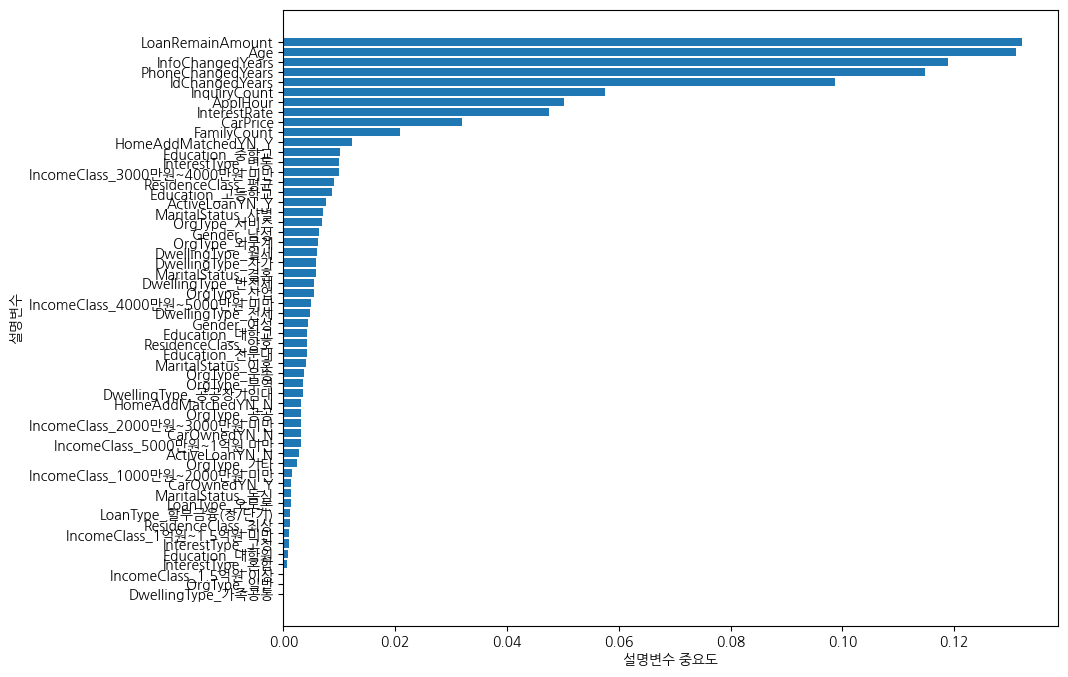

In [54]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_importance .sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## XGBoost

In [55]:
# xgboost 패키지 불러오기
from xgboost import XGBClassifier

# 변수 중요도 확인: F1 점수 기준
from xgboost import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [56]:
# 기본 모델 지정 및 기본 옵션 확인
xgboost_uncust = XGBClassifier()

xgboost_uncust
# xgboost_uncust.get_params()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [57]:
# 모델 적합
xgboost_uncust.fit(df_train_x, df_train_y)

print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
xgb_pred_train = xgboost_uncust.predict(df_train_x)
# 모델 평가
eval_class_model(df_train_y, xgb_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
xgb_pred_test = xgboost_uncust.predict(df_test_x)
# 모델 평가
eval_class_model(df_test_y, xgb_pred_test)


 모델 생성 및 평가 : Train 

오차행렬:
 [[9156    0]
 [  56  452]] 

정확도: 0.9942
정밀도: 1.0000
재현율: 0.8898
F1    : 0.9417
AUC   : 0.9449

 모델 생성 및 평가 : Test 

오차행렬:
 [[3907    6]
 [ 227    2]] 

정확도: 0.9437
정밀도: 0.2500
재현율: 0.0087
F1    : 0.0169
AUC   : 0.5036


In [58]:
# sklearn XGBoost 모델의 조기 중단:fit( )에 파라미터 입력(early_stopping_rounds, eval_metrics, eval_set.)
# 모델 파라미터 지정:n_estimators, learning_rate, max_depth 등 지정
# 조기 중간 파라미터 지정: early_stopping_rounds
# 평가지표 지정:logloss

# 모델 성능 평가 데이터
eval_df = [(df_test_x, df_test_y)]

xgb_stop = XGBClassifier(n_estimators = 300, learning_rate = 0.1 , max_depth = 6)
xgb_stop.fit(df_train_x, df_train_y,
            # 조기 중단 파라미터
             early_stopping_rounds = 150, eval_metric="logloss", eval_set = eval_df, verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.24678
[1]	validation_0-logloss:0.24115
[2]	validation_0-logloss:0.23615
[3]	validation_0-logloss:0.23178
[4]	validation_0-logloss:0.22808
[5]	validation_0-logloss:0.22507
[6]	validation_0-logloss:0.22238
[7]	validation_0-logloss:0.22027
[8]	validation_0-logloss:0.21829
[9]	validation_0-logloss:0.21652
[10]	validation_0-logloss:0.21515
[11]	validation_0-logloss:0.21424
[12]	validation_0-logloss:0.21308
[13]	validation_0-logloss:0.21234
[14]	validation_0-logloss:0.21139
[15]	validation_0-logloss:0.21091
[16]	validation_0-logloss:0.21008
[17]	validation_0-logloss:0.20990
[18]	validation_0-logloss:0.20954
[19]	validation_0-logloss:0.20926
[20]	validation_0-logloss:0.20896
[21]	validation_0-logloss:0.20889
[22]	validation_0-logloss:0.20874
[23]	validation_0-logloss:0.20900
[24]	validation_0-logloss:0.20893
[25]	validation_0-logloss:0.20874
[26]	validation_0-logloss:0.20877
[27]	validation_0-logloss:0.20900
[28]	validation_0-logloss:0.20886
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
# 최적 모델 정보 확인
print("최적 횟수:",xgb_stop.best_iteration)
print("최적 성능(0-LogLoss):",xgb_stop.best_score)

최적 횟수: 25
최적 성능(0-LogLoss): 0.20873501658541269


{'Age': 688.0, 'FamilyCount': 193.0, 'InterestRate': 354.0, 'ApplHour': 313.0, 'CarPrice': 198.0, 'InquiryCount': 277.0, 'LoanRemainAmount': 666.0, 'IdChangedYears': 598.0, 'InfoChangedYears': 718.0, 'PhoneChangedYears': 625.0, 'Gender_남성': 68.0, 'Education_고등학교': 75.0, 'Education_대학교': 35.0, 'Education_대학원': 19.0, 'Education_전문대': 33.0, 'Education_중학교': 43.0, 'MaritalStatus_결혼': 45.0, 'MaritalStatus_독신': 10.0, 'MaritalStatus_사별': 44.0, 'MaritalStatus_이혼': 16.0, 'IncomeClass_1000만원~2000만원 미만': 8.0, 'IncomeClass_1억원~1.5억원 미만': 6.0, 'IncomeClass_2000만원~3000만원 미만': 32.0, 'IncomeClass_3000만원~4000만원 미만': 30.0, 'IncomeClass_4000만원~5000만원 미만': 37.0, 'IncomeClass_5000만원~1억원 미만': 31.0, 'OrgType_공공': 10.0, 'OrgType_기타': 5.0, 'OrgType_무역': 37.0, 'OrgType_산업': 47.0, 'OrgType_서비스': 49.0, 'OrgType_외국계': 28.0, 'OrgType_운송': 19.0, 'DwellingType_공공장기임대': 13.0, 'DwellingType_반전세': 40.0, 'DwellingType_월세': 31.0, 'DwellingType_자가': 61.0, 'DwellingType_전세': 36.0, 'ResidenceClass_양호': 25.0, 'ResidenceClass_

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

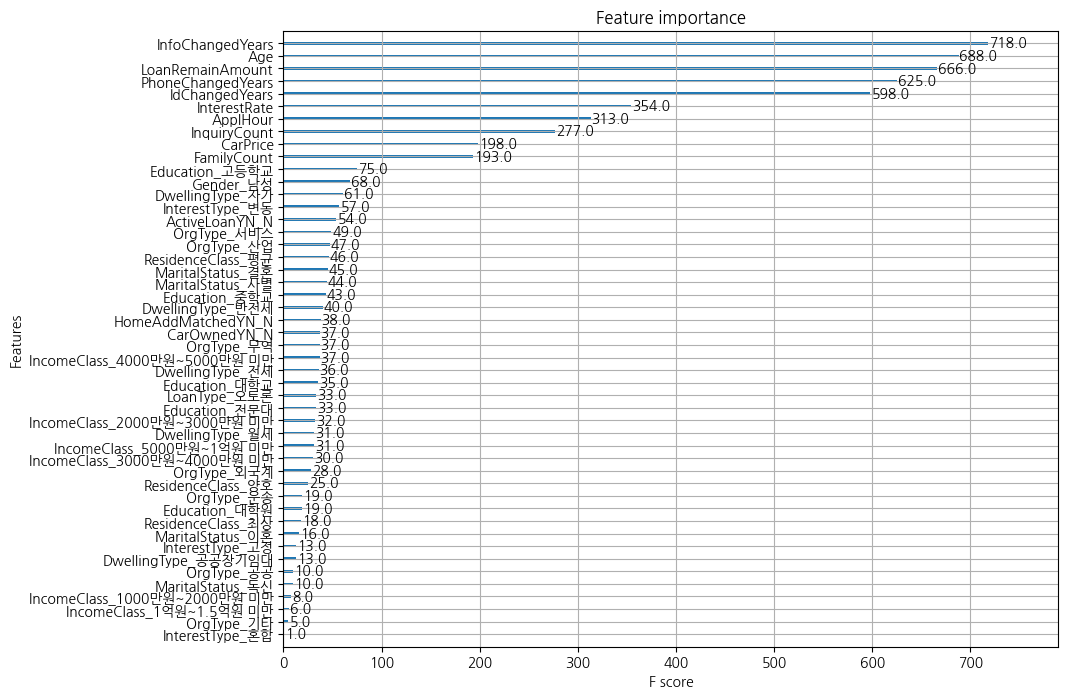

In [60]:
# 변수 중요도 확인
from xgboost import plot_importance  # F1 score 기준으로 변수 중요도 표시(변경 가능)
print(xgb_stop.get_booster().get_fscore())
""
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_stop, ax=ax)

## LightGBM

In [61]:
# LightGBM 패키지 불러오기
from lightgbm import LGBMClassifier

# 변수 중요도 확인: F1 점수 기준
from lightgbm import plot_importance

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [62]:
# 기본 모델 지정 및 기본 옵션 확인
lgbm_uncust = LGBMClassifier()

lgbm_uncust.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [63]:
# 모델 적합
lgbm_uncust.fit(df_train_x, df_train_y)
print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
lgbm_pred_train = lgbm_uncust.predict(df_train_x)
eval_class_model(df_train_y, lgbm_pred_train)
print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
lgbm_pred_test = lgbm_uncust.predict(df_test_x)
eval_class_model(df_test_y, lgbm_pred_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 508, number of negative: 9156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 9664, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052566 -> initscore=-2.891683
[LightGBM] [Info] Start training from score -2.891683

 모델 생성 및 평가 : Train 

오차행렬:
 [[9156    0]
 [ 339  169]] 

정확도: 0.9649
정밀도: 1.0000
재현율: 0.3327
F1    : 0.4993
AUC   : 0.6663

 모델 생성 및 평가 : Test 

오차행렬:
 [[3913    0]
 [ 228    1]] 

정확도: 0.9450
정밀도: 1.0000
재현율: 0.0044
F1    : 0.0087
AUC   : 0.5022


In [64]:
# 사용자 모델 생성
lgbm_user= LGBMClassifier(n_estimators = 100, learning_rate = 0.1, max_depth = 6)
# 모델 적합
lgbm_user.fit(df_train_x, df_train_y)

# 예측 및 모델 평가:Train
lgbm_pred_train = lgbm_user.predict(df_train_x)

eval_class_model(df_train_y, lgbm_pred_train)
print('\n',classification_report(df_train_y, lgbm_pred_train))

# 예측 및 모델 평가:Test
lgbm_pred_test = lgbm_user.predict(df_test_x)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, lgbm_pred_test)
print('\n',classification_report(df_test_y, lgbm_pred_test))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 508, number of negative: 9156
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1144
[LightGBM] [Info] Number of data points in the train set: 9664, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052566 -> initscore=-2.891683
[LightGBM] [Info] Start training from score -2.891683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

['Age', 'FamilyCount', 'InterestRate', 'ApplHour', 'CarPrice', 'InquiryCount', 'LoanRemainAmount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원_이상', 'IncomeClass_1000만원~2000만원_미만', 'IncomeClass_1억원~1.5억원_미만', 'IncomeClass_2000만원~3000만원_미만', 'IncomeClass_3000만원~4000만원_미만', 'IncomeClass_4000만원~5000만원_미만', 'IncomeClass_5000만원~1억원_미만', 'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동', 'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호', 'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N', 'CarOwnedYN_Y', 'ActiveLoanYN_N', 'ActiveLoanYN_Y', 'LoanType_오토론', 'LoanType_할부금융(장/단기)', 'InterestType_고정', 'InterestType_변동'

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

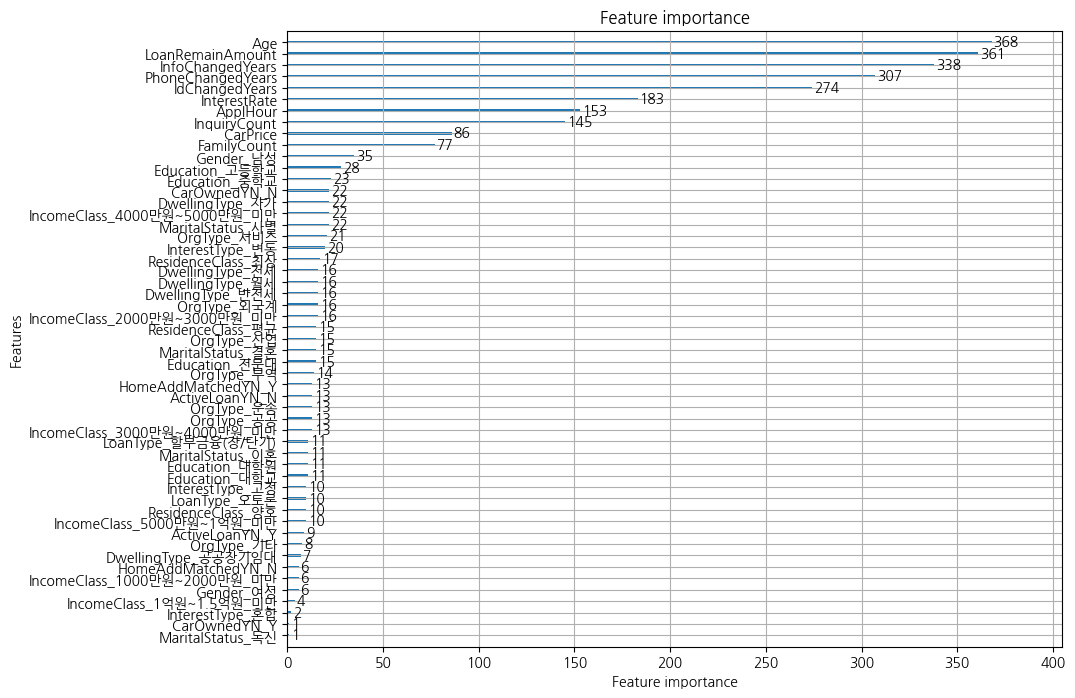

In [65]:
# 변수 중요도 확인
from lightgbm import plot_importance
print(lgbm_user.feature_name_)
print(lgbm_user.feature_importances_)

fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(lgbm_user, ax=ax)

## CatBoost

In [67]:
!pip3 install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.7 MB/s eta 0:00:00


In [68]:
# 패키지 불러오기
from catboost import CatBoostClassifier

# 분류모델 통합 평가: 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 등
def eval_class_model(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)

    print('오차행렬:\n', confusion, '\n')
    print('정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1    : {:.4f}'.format(F1))
    print('AUC   : {:.4f}'.format(AUC))

In [69]:
# 기본 모델 지정 및 기본 옵션 확인
cbc_uncust = CatBoostClassifier()

cbc_uncust.get_all_params

<bound method CatBoost.get_all_params of <catboost.core.CatBoostClassifier object at 0x782b4cd3b700>>

In [70]:
# 모델 적합
cbc_uncust.fit(df_train_x, df_train_y)

print('\n 모델 생성 및 평가 : Train \n')
# 예측 및 모델 평가:train
cbc_pred_train = cbc_uncust.predict(df_train_x)
eval_class_model(df_train_y, cbc_pred_train)

print('\n 모델 생성 및 평가 : Test \n')
# 예측 및 모델 평가:test
cbc_pred_test = cbc_uncust.predict(df_test_x)
eval_class_model(df_test_y, cbc_pred_test)

Learning rate set to 0.027139
0:	learn: 0.6582039	total: 57.3ms	remaining: 57.3s
1:	learn: 0.6262628	total: 72.4ms	remaining: 36.1s
2:	learn: 0.5963882	total: 87.7ms	remaining: 29.2s
3:	learn: 0.5684488	total: 97.9ms	remaining: 24.4s
4:	learn: 0.5427086	total: 110ms	remaining: 21.8s
5:	learn: 0.5188066	total: 134ms	remaining: 22.1s
6:	learn: 0.4964223	total: 150ms	remaining: 21.2s
7:	learn: 0.4756439	total: 177ms	remaining: 22s
8:	learn: 0.4564310	total: 188ms	remaining: 20.7s
9:	learn: 0.4387120	total: 208ms	remaining: 20.6s
10:	learn: 0.4224492	total: 224ms	remaining: 20.1s
11:	learn: 0.4070531	total: 232ms	remaining: 19.1s
12:	learn: 0.3927799	total: 251ms	remaining: 19.1s
13:	learn: 0.3794196	total: 267ms	remaining: 18.8s
14:	learn: 0.3672859	total: 290ms	remaining: 19.1s
15:	learn: 0.3559328	total: 303ms	remaining: 18.7s
16:	learn: 0.3456167	total: 309ms	remaining: 17.8s
17:	learn: 0.3357018	total: 313ms	remaining: 17.1s
18:	learn: 0.3267760	total: 320ms	remaining: 16.5s
19:	learn

In [71]:
# 사용자 모델 생성
cbc_user= CatBoostClassifier(n_estimators = 200, learning_rate = 0.1, max_depth = 7)
# 모델 적합
cbc_user.fit(df_train_x, df_train_y)

# 예측 및 모델 평가:Train
cbc_pred_train = cbc_user.predict(df_train_x)

print('\n 사용자 모델 평가 : Train \n')
eval_class_model(df_train_y, cbc_pred_train)
print('\n',classification_report(df_train_y, cbc_pred_train))


# 예측 및 모델 평가:Test
cbc_pred_test = cbc_user.predict(df_test_x)

print('\n 사용자 모델 평가 : Test \n')
eval_class_model(df_test_y, cbc_pred_test)
print('\n',classification_report(df_test_y, cbc_pred_test))

0:	learn: 0.5719024	total: 30ms	remaining: 5.97s
1:	learn: 0.4814936	total: 50.3ms	remaining: 4.98s
2:	learn: 0.4131848	total: 103ms	remaining: 6.79s
3:	learn: 0.3624784	total: 143ms	remaining: 7.03s
4:	learn: 0.3248162	total: 166ms	remaining: 6.46s
5:	learn: 0.2959337	total: 190ms	remaining: 6.13s
6:	learn: 0.2741447	total: 219ms	remaining: 6.03s
7:	learn: 0.2567745	total: 254ms	remaining: 6.1s
8:	learn: 0.2437856	total: 282ms	remaining: 5.98s
9:	learn: 0.2335002	total: 291ms	remaining: 5.54s
10:	learn: 0.2259610	total: 322ms	remaining: 5.53s
11:	learn: 0.2197766	total: 349ms	remaining: 5.46s
12:	learn: 0.2145157	total: 364ms	remaining: 5.23s
13:	learn: 0.2105694	total: 382ms	remaining: 5.08s
14:	learn: 0.2075407	total: 394ms	remaining: 4.86s
15:	learn: 0.2043865	total: 407ms	remaining: 4.68s
16:	learn: 0.2013572	total: 423ms	remaining: 4.56s
17:	learn: 0.1996572	total: 435ms	remaining: 4.4s
18:	learn: 0.1976455	total: 443ms	remaining: 4.21s
19:	learn: 0.1959868	total: 450ms	remaining

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

In [72]:
# 모델 성능 평가 데이터
eval_df = [(df_test_x, df_test_y)]

cbc_stop = CatBoostClassifier(n_estimators = 300, learning_rate = 0.1 , max_depth = 6)

cbc_stop.fit(df_train_x, df_train_y,
            # 조기 중단 파라미터
             early_stopping_rounds = 150,eval_set = eval_df, verbose=True)
# cbc_stop.fit(df_train_x, df_train_y,
#             # 조기 중단 파라미터
#              early_stopping_rounds = 150, eval_metric="auto", eval_set = eval_df,
#              verbose=True)

0:	learn: 0.5724217	test: 0.5740131	best: 0.5740131 (0)	total: 25.4ms	remaining: 7.6s
1:	learn: 0.4831675	test: 0.4853420	best: 0.4853420 (1)	total: 30.9ms	remaining: 4.61s
2:	learn: 0.4155152	test: 0.4184516	best: 0.4184516 (2)	total: 42.7ms	remaining: 4.23s
3:	learn: 0.3640942	test: 0.3676217	best: 0.3676217 (3)	total: 56.3ms	remaining: 4.17s
4:	learn: 0.3258338	test: 0.3302270	best: 0.3302270 (4)	total: 74.4ms	remaining: 4.39s
5:	learn: 0.2973970	test: 0.3023943	best: 0.3023943 (5)	total: 90.7ms	remaining: 4.44s
6:	learn: 0.2753678	test: 0.2810280	best: 0.2810280 (6)	total: 109ms	remaining: 4.57s
7:	learn: 0.2592485	test: 0.2653116	best: 0.2653116 (7)	total: 121ms	remaining: 4.4s
8:	learn: 0.2460143	test: 0.2529755	best: 0.2529755 (8)	total: 141ms	remaining: 4.54s
9:	learn: 0.2362854	test: 0.2436879	best: 0.2436879 (9)	total: 176ms	remaining: 5.11s
10:	learn: 0.2287080	test: 0.2364519	best: 0.2364519 (10)	total: 190ms	remaining: 4.99s
11:	learn: 0.2226744	test: 0.2307940	best: 0.230

In [73]:
# 최적모델 정보 확인
print("최적 횟수:",cbc_stop.best_iteration_)
print("최적 성능:",cbc_stop.best_score_)

최적 횟수: 53
최적 성능: {'learn': {'Logloss': 0.12162275503802773}, 'validation': {'Logloss': 0.20701465985211648}}


In [74]:
# 조기 중단 예측 및 모델 평가:Test
cbc_pred_stop = cbc_stop.predict(df_test_x)

print('\n 조기 중단 모델 평가 : Test \n')
eval_class_model(df_test_y, cbc_pred_stop)
print('\n',classification_report(df_test_y, cbc_pred_stop))


 조기 중단 모델 평가 : Test 

오차행렬:
 [[3913    0]
 [ 229    0]] 

정확도: 0.9447
정밀도: 0.0000
재현율: 0.0000
F1    : 0.0000
AUC   : 0.5000

               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3913
           1       0.00      0.00      0.00       229

    accuracy                           0.94      4142
   macro avg       0.47      0.50      0.49      4142
weighted avg       0.89      0.94      0.92      4142



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

In [75]:
# 변수 중요도 확인
print(cbc_stop.feature_names_)
print(cbc_stop.feature_importances_)
# print(cbc_stop.get_feature_importance())

['Age', 'FamilyCount', 'InterestRate', 'ApplHour', 'CarPrice', 'InquiryCount', 'LoanRemainAmount', 'IdChangedYears', 'InfoChangedYears', 'PhoneChangedYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교', 'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교', 'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별', 'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상', 'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만', 'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만', 'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만', 'OrgType_공공', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업', 'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'OrgType_일반', 'DwellingType_가족공동', 'DwellingType_공공장기임대', 'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가', 'DwellingType_전세', 'ResidenceClass_양호', 'ResidenceClass_최상', 'ResidenceClass_평균', 'CarOwnedYN_N', 'CarOwnedYN_Y', 'ActiveLoanYN_N', 'ActiveLoanYN_Y', 'LoanType_오토론', 'LoanType_할부금융(장/단기)', 'InterestType_고정', 'InterestType_변동'

In [76]:
# 변수명
v_feature_name = df_train_x.columns
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_cbc_importance = pd.DataFrame()
df_cbc_importance ["Feature"] = cbc_stop.feature_names_
df_cbc_importance ["Importance"] = cbc_stop.feature_importances_
# 중요도별로 정렬
df_cbc_importance .sort_values("Importance", ascending=False, inplace = True)
df_cbc_importance .round(3)

,Feature,Importance
9,PhoneChangedYears,8.353
5,InquiryCount,7.539
7,IdChangedYears,7.449
0,Age,7.091
8,InfoChangedYears,6.916
3,ApplHour,5.060
4,CarPrice,4.870
1,FamilyCount,4.402
11,Gender_여성,3.557
6,LoanRemainAmount,3.186


Text(0, 0.5, '설명변수')

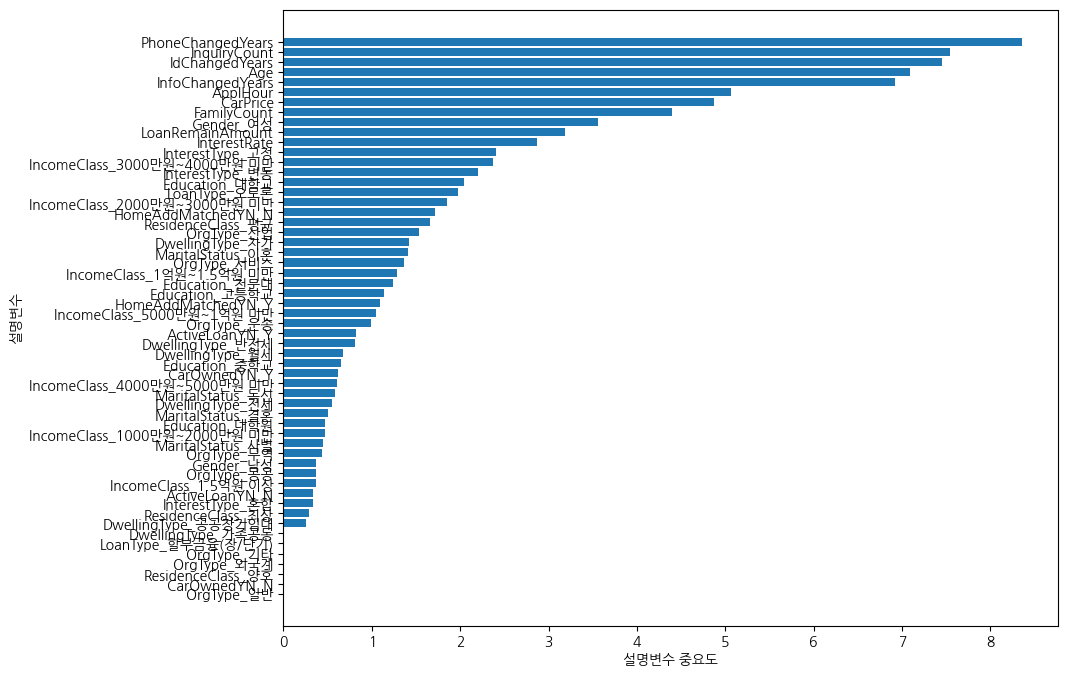

In [77]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
fig, ax = plt.subplots(figsize=(10, 8))

df_cbc_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_cbc_importance ))
plt.barh(y = coordinates, width = df_cbc_importance ["Importance"])
plt.yticks(coordinates, df_cbc_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

# TEST

In [78]:
df = pd.merge(dfc_test,dfloan_test, how='right',on='CustomerId')

In [ ]:
df = df.drop(['CustomerId','LoanId','HouseAge', 'WorkAddMatchedYN'], axis = 1)
df_em = df[(df['IncomeType'] == '퇴직')]
df_em = df_em.drop('EmployedYears', axis=1)

In [ ]:
df_em = df_em.dropna(subset=['PhoneChangeYears'])
df_em = df_em.dropna(subset=['IdChangedYears'])

In [ ]:
df_em = df_em.drop(['ScoreA', 'ScoreB','ScoreC','Occupation', 'IncomeType'], axis=1)

In [ ]:
df_em.isnull().sum()

Gender                 0
Age                    0
Education              0
MaritalStatus          0
FamilyCount            0
ChildCount             0
IncomeClass            0
OrgType                0
HouseOwnYN             0
DwellingType           0
HousingType            0
ResidenceClass         0
CarOwnedYN             0
Default             7763
ActiveLoanYN           0
LoanType               0
ApplWeek               0
ApplHour               0
Accompany              0
CarPrice               0
Deposit                0
LoanTerm               0
LoanRemainTerm         0
InterestType           0
InterestRate        7763
LoanAmount             0
InstallAmount       7763
LoanRemainAmount       0
HomeAddMatchedYN       0
InquiryCount           0
IdChangedYears         0
InfoChangedYears       0
PhoneChangeYears       0
dtype: int64

In [ ]:
df_em = df_em[df_em['IncomeClass'] != '누락']
df_em = df_em[df_em['ResidenceClass'] != '누락']
df_em = df_em[df_em['DwellingType'] != '정보누락']

In [ ]:
df_em['Accompany'].replace(['기타','배우자','친지','자녀','단체'],'동행', inplace = True)

In [ ]:
df_em = df_em.drop(['Default', 'InterestRate','InstallAmount'], axis=1)

* 신규 고객 데이터이기 때문에 연체여부, 금리, 월납입금액 삭제

In [ ]:
df_test = pd.get_dummies(df_em)

In [ ]:
# df_test

In [ ]:
import lightgbm as lgb
from xgboost import XGBClassifier as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
print(df_test.columns)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

Index(['Age', 'FamilyCount', 'ChildCount', 'ApplHour', 'CarPrice', 'Deposit',
       'LoanTerm', 'LoanRemainTerm', 'LoanAmount', 'LoanRemainAmount',
       'InquiryCount', 'IdChangedYears', 'InfoChangedYears',
       'PhoneChangeYears', 'Gender_남성', 'Gender_여성', 'Education_고등학교',
       'Education_대학교', 'Education_대학원', 'Education_전문대', 'Education_중학교',
       'MaritalStatus_결혼', 'MaritalStatus_독신', 'MaritalStatus_사별',
       'MaritalStatus_이혼', 'IncomeClass_1.5억원 이상',
       'IncomeClass_1000만원~2000만원 미만', 'IncomeClass_1억원~1.5억원 미만',
       'IncomeClass_2000만원~3000만원 미만', 'IncomeClass_3000만원~4000만원 미만',
       'IncomeClass_4000만원~5000만원 미만', 'IncomeClass_5000만원~1억원 미만',
       'OrgType_공공', 'OrgType_군/경', 'OrgType_기타', 'OrgType_무역', 'OrgType_산업',
       'OrgType_서비스', 'OrgType_외국계', 'OrgType_운송', 'HouseOwnYN_N',
       'HouseOwnYN_Y', 'DwellingType_가족공동', 'DwellingType_공공장기임대',
       'DwellingType_반전세', 'DwellingType_월세', 'DwellingType_자가',
       'DwellingType_전세', 'HousingType_단독주택

In [ ]:
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (9664, 57)
train data Y size : (9664,)
test data X size : (4142, 57)
test data Y size : (4142,)


In [ ]:
params = {'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

X_train, X_valid, y_train, y_valid = train_test_split(df_train_x, df_train_y, test_size=0.2)

xgboost_uncust


train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

* accuracy 점수가 가장 높은 LightGBM 모델 선택 (0.172)

In [ ]:
num_round = 1000
bst = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data])

/home/piai/anaconda3/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 870
[LightGBM] [Info] Number of data points in the train set: 7731, number of used features: 55
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.054068


In [ ]:
# 테스트 데이터 로드 또는 생성
X_test= df_test_x
# 모델을 사용하여 예측

In [ ]:
X_test

,Age,InterestRate,InquiryCount,IdChangedYears,InfoChangedYears,PhoneChangedYears,Gender_남성,Gender_여성,Education_고등학교,Education_대학교,...,ApplWeek_금,ApplWeek_목,ApplWeek_수,ApplWeek_월,ApplWeek_화,InterestType_고정,InterestType_변동,InterestType_혼합,HomeAddMatchedYN_N,HomeAddMatchedYN_Y
4547,60.2,5.19,0,12.5,0.0,2.2,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1
19294,61.5,4.43,0,8.5,1.9,1.8,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
3563,63.3,5.19,1,0.0,33.4,8.1,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
46359,65.5,5.10,0,12.5,17.1,1.1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
80738,62.5,5.23,5,2.5,2.4,2.1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66903,56.0,4.43,4,10.7,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
8576,56.5,4.30,1,10.6,9.2,0.7,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1
87388,61.3,6.83,0,13.5,1.3,4.9,1,0,0,1,...,0,0,0,1,0,0,1,0,0,1
42002,52.2,4.43,8,0.0,1.6,2.3,1,0,0,1,...,0,0,0,0,1,0,1,0,0,1


In [ ]:
predictions = bst.predict(X_test, num_iteration=bst.best_iteration)

In [ ]:
# 예측값 (이진 분류의 경우 0 또는 1)
binary_predictions = (predictions > 0.4).astype(int)

# 예측 확률
predictions[predictions < 0] = 0.01
prediction_probabilities = predictions

# 결과 확인
results = pd.DataFrame({'Prediction': binary_predictions, 'Probability': prediction_probabilities})
results

,Prediction,Probability
0,0,0.063291
1,0,0.030843
2,0,0.181886
3,0,0.029014
4,0,0.092533
...,...,...
4137,0,0.073136
4138,0,0.082577
4139,0,0.010000
4140,0,0.145595


* 연체일 확률이 40%보다 높으면 1로 분류, 낮으면 0으로 분류

In [ ]:
results['Prediction'].value_counts()

0    4136
1       6
Name: Prediction, dtype: int64

In [ ]:
results[results['Prediction'] == 1]

,Prediction,Probability
308,1,0.497116
682,1,0.491376
1236,1,0.453816
1374,1,0.484783
1803,1,0.413382
2693,1,0.631411


* 신규 고객 데이터에서 연체 위험 고객 6명 확인

* 확률을 활용하여 등급 세분화

  (1-P)*1000 = 신용 점수

## 결론

- 연체예측 모델을 만들고, 신규 데이터에 대해 연체 여부를 예측해 보았다.
- SMOTE 기법을 사용했을 때 F1-SCORE 값이 크게 증가하는 것은 추후 더 많은 데이터가 수집되었을 때 모델의 성능이 더욱 올라갈 수 있음을 방증
- 연체될 확률 값을 가지고 점수로 환산하여 구간별 금리 책정 가능
- 더 많은 변수가 추가될 시 연체 예측 모델의 성능 향상을 기대할 수 있음.